In [29]:
!pip install wordcloud

In [70]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import joblib
import os


In [48]:
# Load dataset
df = pd.read_csv("C:/Users/sowjanya/Desktop/Data Science Projects/Spam Email Classifier/email_spam.csv", encoding='ISO-8859-1')

# Check first few rows and structure
print(df.head())
print(df.info())

# Dropping unnecessary columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

# Rename columns
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

# Encode the target variable (ham=0, spam=1)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
m

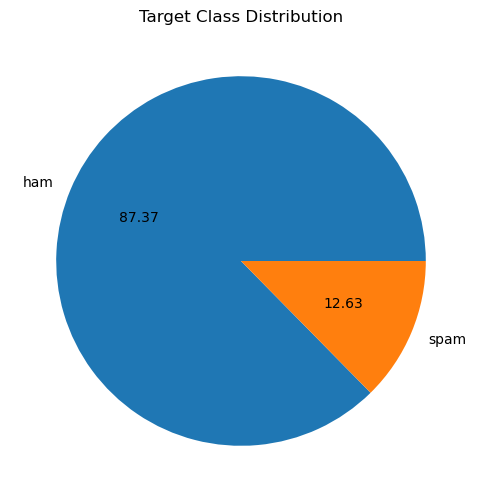

In [50]:
# Check for missing values and duplicates
df = df.drop_duplicates()
df.isnull().sum()

# Data Distribution for target variable
plt.figure(figsize=(6, 6))
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct='%.2f')
plt.title("Target Class Distribution")
plt.show()


          num_char    num_words  num_sentences
count  5169.000000  5169.000000    5169.000000
mean     78.977945    18.455794       1.965564
std      58.236293    13.324758       1.448541
min       2.000000     1.000000       1.000000
25%      36.000000     9.000000       1.000000
50%      60.000000    15.000000       1.000000
75%     117.000000    26.000000       2.000000
max     910.000000   220.000000      38.000000


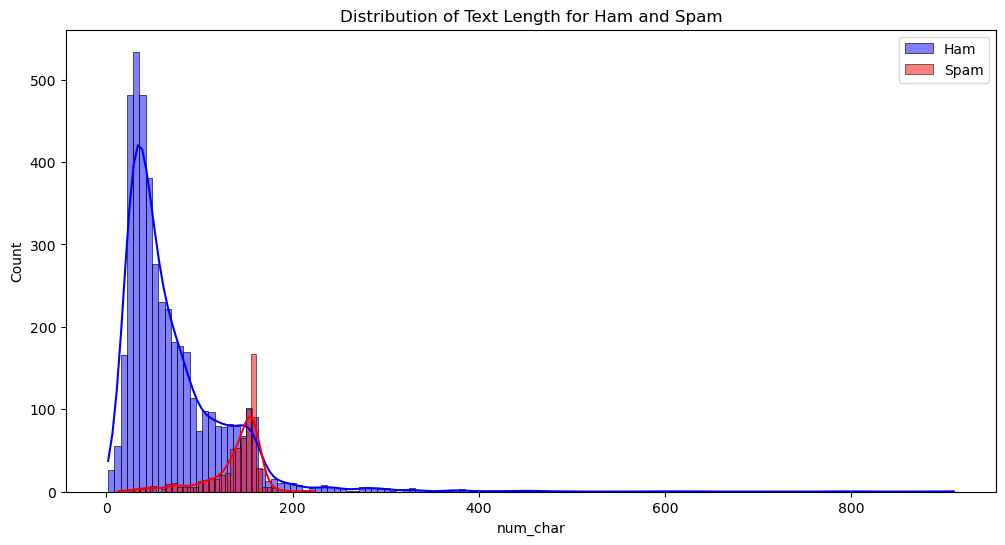

In [52]:
# Basic text length analysis
df['num_char'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Statistics on text lengths
print(df[['num_char', 'num_words', 'num_sentences']].describe())

# Visualize text length distributions
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target'] == 0]['num_char'], color='blue', label='Ham', kde=True)
sns.histplot(df[df['target'] == 1]['num_char'], color='red', label='Spam', kde=True)
plt.legend()
plt.title("Distribution of Text Length for Ham and Spam")
plt.show()


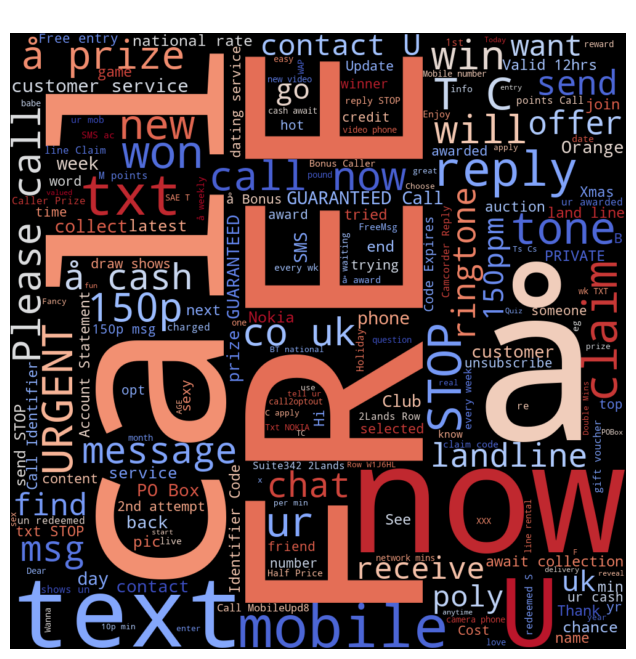

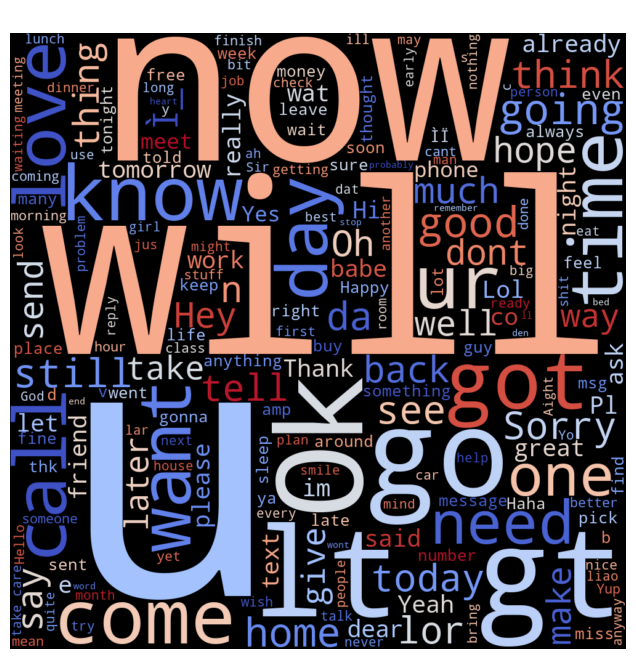

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a unique WordCloud with a different colormap
wc = WordCloud(width=1000, height=1000, min_font_size=10, background_color='black', colormap='coolwarm')

# Spam WordCloud
spam_wc = wc.generate(df[df['target'] == 1]['text'].str.cat(sep=" "))
plt.figure(figsize=(10, 8))
plt.imshow(spam_wc, interpolation='bilinear')
plt.title('Spam Email WordCloud (Coolwarm Theme)', fontsize=14, color='white')
plt.axis('off')
plt.show()

# Ham WordCloud
ham_wc = wc.generate(df[df['target'] == 0]['text'].str.cat(sep=" "))
plt.figure(figsize=(10, 8))
plt.imshow(ham_wc, interpolation='bilinear')
plt.title('Ham Email WordCloud (Coolwarm Theme)', fontsize=14, color='white')
plt.axis('off')
plt.show()


In [56]:
# Preprocessing the text (lowercase, remove punctuation, stopwords, stemming)
nltk.download('punkt')
nltk.download('stopwords')
ps = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    text = [word for word in text if word.isalnum()]
    text = [word for word in text if word not in stopwords.words('english') and word not in string.punctuation]
    text = [ps.stem(word) for word in text]
    
    return " ".join(text)

df['processed_text'] = df['text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sowjanya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sowjanya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
# Convert text data to numerical data using TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['processed_text']).toarray()
y = df['target'].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [72]:
# Define models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(kernel='linear'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate models
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision    Recall  F1-Score
0          Naive Bayes  0.972921   0.991597  0.813793  0.893939
1  Logistic Regression  0.958414   0.947368  0.744828  0.833977
2                  SVM  0.982592   0.984733  0.889655  0.934783
3        Decision Tree  0.951644   0.827586  0.827586  0.827586
4        Random Forest  0.972921   0.991597  0.813793  0.893939
5                  KNN  0.916828   1.000000  0.406897  0.578431


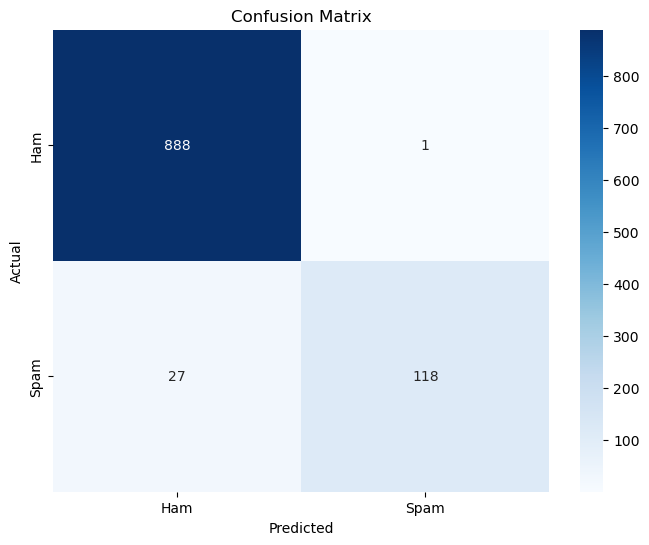

In [62]:
# Confusion Matrix for the best model (for example, Naive Bayes)
best_model = models['Naive Bayes']
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


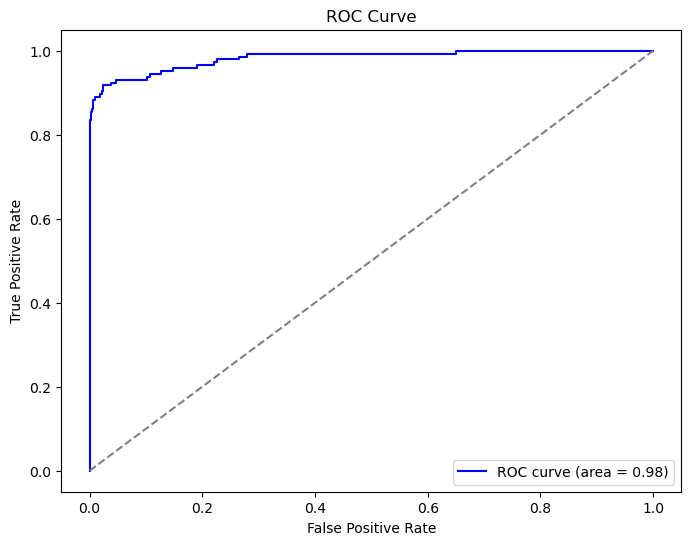

In [64]:
# Plot ROC Curve for Naive Bayes
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [66]:
# Save the best performing model (Naive Bayes) and the TF-IDF vectorizer

# Save path
model_save_path = r"C:\Users\sowjanya\Desktop\Data Science Projects\Spam Email Classifier\models"
os.makedirs(model_save_path, exist_ok=True)

# Save the model
model_filename = os.path.join(model_save_path, 'best_spam_classifier_model.pkl')
joblib.dump(best_model, model_filename)

# Save the vectorizer
vectorizer_filename = os.path.join(model_save_path, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf, vectorizer_filename)

print(f"Model and Vectorizer have been saved at {model_save_path}")


Model and Vectorizer have been saved at C:\Users\sowjanya\Desktop\Data Science Projects\Spam Email Classifier\models


In [76]:
# Select the best model (highest ROC AUC)
best_model_name = results_df.iloc[0]['Model']
print(f"\nBest Model for Deployment: {best_model_name}")

# Train the best model
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# Final Evaluation: Classification Report for the best model
y_pred_best = best_model.predict(X_test)
print(f"\nClassification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best))

# Save the best model
model_save_path = "C:/Users/sowjanya/Desktop/Data Science Projects/Spam Email Classifier/models/best_spam_model.pkl"
joblib.dump(best_model, model_save_path)
print(f"Best model saved to {model_save_path}")


Best Model for Deployment: Naive Bayes

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       889
           1       0.99      0.81      0.89       145

    accuracy                           0.97      1034
   macro avg       0.98      0.91      0.94      1034
weighted avg       0.97      0.97      0.97      1034

Best model saved to C:/Users/sowjanya/Desktop/Data Science Projects/Spam Email Classifier/models/best_spam_model.pkl
